## Import Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

## Data preprocessing

### Read data

In [23]:
stock_ntr = pd.read_csv('../../../Dataset/NTR.csv')
stock_ntr

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [24]:
# Convert the 'Date' column to datetime format
stock_ntr['Date'] = pd.to_datetime(stock_ntr['Date'])

# Set the 'Date' column as the index value
stock_ntr = stock_ntr.set_index(pd.DatetimeIndex(stock_ntr['Date'].values))

# Create new datafram with Date and Close
df_ntr = pd.DataFrame(stock_ntr, columns=['Close'])

### Data normalization

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))
df_ntr = scaler.fit_transform(np.array(df_ntr).reshape(-1,1))

### Data splitting

In [26]:
# Length
    # Train: 60%
    # Val: 20%
    # Test: 20%
train_size = int(len(df_ntr) * 0.6)
val_size = int(len(df_ntr) * 0.2)
test_size = len(df_ntr) - train_size - val_size

In [27]:
# Get Data 
train_data = df_ntr[:train_size]
val_data = df_ntr[train_size:train_size+val_size]
test_data = df_ntr[train_size+val_size:]

In [28]:
# Create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset) - time_step):
		a = dataset[i:(i + time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [29]:
# Reshape into X=t,t+1,t+2..t+100 and Y=t+100
time_step = 100

# Get lost data for test
train_last_windowsize = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_windowsize, val_data), axis=0)

# Get lost data for val
val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data_extended, time_step)
X_test, ytest = create_dataset(test_data_extended, time_step)

In [30]:
# Tạo input cho dữ liệu đầu vào LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

## Model training and testing

In [31]:
# Define model
    # Pack the sequence of the inner layers
model = Sequential()
    # LSTM with 64 units with reture_sequences = true => preidct along to the series
model.add(LSTM(64, return_sequences=True, input_shape = (time_step, 1)))
    # LSTM with 64 units with reture_sequences = false => get the last predict
model.add(LSTM(64, return_sequences=False, input_shape = (time_step, 1)))
    # Dropout: Avoid remembering too much information => disable part of the previous data
model.add(Dropout(0.2))
    # 1 Dense layer (dense): 1 unit provides predictive value, using activiation function: relu
model.add(Dense(1,activation='relu'))
    # Compile model with loss function: MST, optimize: adam 
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
# Using earlystopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=10)

In [33]:
# Training LSTM model
model.fit(X_train, y_train, validation_data=(X_val, yval), epochs = 100, batch_size = 64,verbose = 1,  callbacks=earlystop)

Epoch 1/100
9/9 [==============================] - 34s 1s/step - loss: 0.0247 - val_loss: 0.0047
Epoch 2/100
9/9 [==============================] - 6s 662ms/step - loss: 0.0040 - val_loss: 0.0451
Epoch 3/100
9/9 [==============================] - 5s 574ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 4/100
9/9 [==============================] - 7s 810ms/step - loss: 0.0021 - val_loss: 0.0164
Epoch 5/100
9/9 [==============================] - 5s 575ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/100
9/9 [==============================] - 6s 681ms/step - loss: 0.0013 - val_loss: 0.0036
Epoch 7/100
9/9 [==============================] - 6s 722ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 8/100
9/9 [==============================] - 4s 452ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 9/100
9/9 [==============================] - 4s 505ms/step - loss: 0.0012 - val_loss: 0.0034
Epoch 10/100
9/9 [==============================] - 5s 513ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 11/10

### Testing process

In [34]:
# Predict
    # Test
y_pred = model.predict(X_test)
    # Val
y_pred_val = model.predict(X_val)

7/7 [==============================] - 2s 234ms/step


### Evaluate model

In [35]:
# Evaluate the accuracy of validate
val_mape = mean_absolute_percentage_error(y_pred_val, yval)
val_mse = mean_squared_error(y_pred_val, yval)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, yval)

print(f"MAPE on Validate dataset: ", val_mape)
print(f"RMSE on Validate dataset: ", val_rmse)
print(f"MSLE on Validate dataset: ", val_msle)

MAPE on Validate dataset:  0.044179024091629784
RMSE on Validate dataset:  0.040250243826098535
MSLE on Validate dataset:  0.0005383296762761449


In [36]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, ytest)
test_mse = mean_squared_error(y_pred, ytest)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, ytest)

print(f"Testing MAPE: ", test_mape)
print(f"Testing RMSE: ", test_rmse)
print(f"Testing MSLE: ", test_msle)

Testing MAPE:  0.040823469171530895
Testing RMSE:  0.032276977322923894
Testing MSLE:  0.0004004532311712309


## Predicting the next 30 days

### Preparing the prediction data

In [37]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])

        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)

        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose = 0)

        temp_input.extend(y_hat[0].tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [38]:
# Print predict next 30 days
print(prediction_next30_days)

[[0.3896353542804718], [0.3962346315383911], [0.3994848430156708], [0.4002033770084381], [0.3990190029144287], [0.3964269757270813], [0.39283496141433716], [0.38859283924102783], [0.38400590419769287], [0.37933868169784546], [0.3748127222061157], [0.37060385942459106], [0.3668401539325714], [0.3636023700237274], [0.3609272837638855], [0.3588123619556427], [0.3572225868701935], [0.3560981750488281], [0.3553617298603058], [0.3549264967441559], [0.35470250248908997], [0.3546023964881897], [0.35454675555229187], [0.35446634888648987], [0.35430553555488586], [0.354022741317749], [0.35359060764312744], [0.3529953956604004], [0.3522353172302246], [0.351318895816803]]


### Preparing the forecast date index

In [39]:
# Get the last date from the current index
last_date = stock_ntr.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [40]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)

In [41]:
# Convert to normal values
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data = scaler.inverse_transform(train_data)
test_data = scaler.inverse_transform(test_data)
val_data = scaler.inverse_transform(val_data)

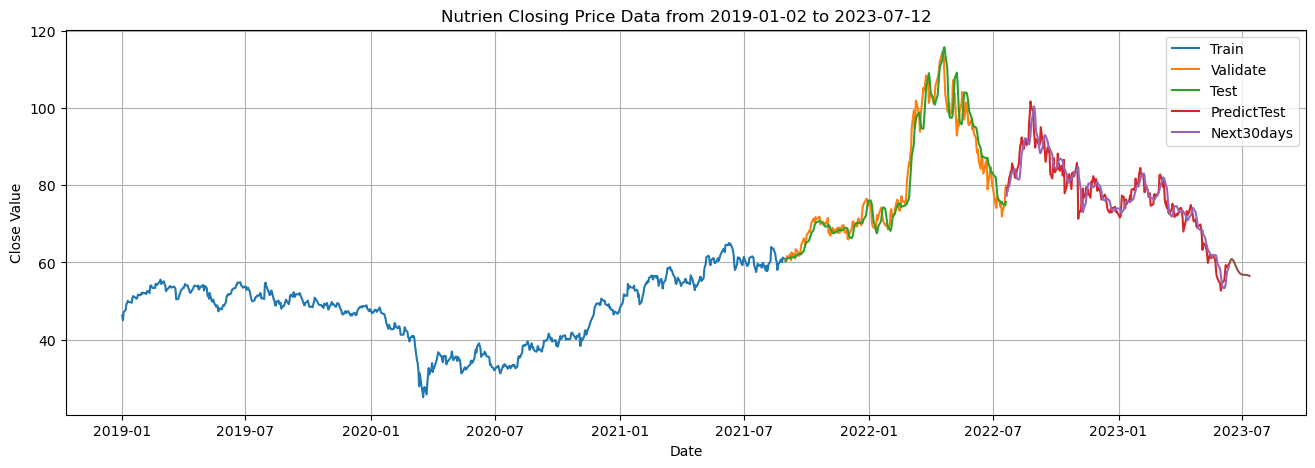

In [42]:
plt.figure(figsize=(16,5))

plt.plot(stock_ntr.index[:train_size], train_data)

plt.plot(stock_ntr.index[train_size:train_size + val_size],val_data)

plt.plot(stock_ntr.index[train_size:train_size + val_size],y_pred_val)

plt.plot(stock_ntr.index[train_size + val_size: ], test_data)

plt.plot(stock_ntr.index[train_size + val_size: ],(y_pred))

plt.plot(future_dates, prediction_next30_days)

plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Nutrien Closing Price Data from 2019-01-02 to 2023-07-12')
plt.legend(['Train','Validate','Test','PredictTest','Next30days'])
plt.grid()
plt.savefig('../Image/LSTM_622_NTR.png')
plt.show()